# Evaluación Comparativa de Modelos CNN en Imágenes Médicas (Kvasir-SEG)

**Autor:** Carlos Eduardo Tiscareño Carreón

**Fecha:** 18 de septiembre del 2025

**Maestria en Ciencia de datos e inteligencia Artificial**

**Materia:** Aprendizaje Profundo

**Profesor:** Dr. Ricardo Abel Espinosa Loera


## Resumen del Proyecto
Este proyecto analiza y compara el desempeño de tres arquitecturas de Redes Neuronales Convolucionales (CNNs) pre-entrenadas para la tarea de clasificación multi-clase de imágenes de endoscopia del dataset Kvasir-v2. Los modelos evaluados son ResNet50, EfficientNet-B0 y DenseNet121.

La evaluación se realiza en base a tres criterios clave:
1.  **Precisión del Modelo:** Accuracy y F1-Score en el conjunto de prueba.
2.  **Costo Computacional:** Tiempo de entrenamiento y número de parámetros.
3.  **Interpretabilidad:** Visualización de las áreas de interés del modelo mediante Grad-CAM.

El código está estructurado para ser completamente reproducible.

In [8]:
# ===================================================================
# 1. CONFIGURACIÓN DEL ENTORNO
# ===================================================================

# 1.1. Montar Google Drive para persistencia de datos
from google.colab import drive
import os

drive.mount('/content/drive')

# 1.2. Importación de Librerías Principales
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, accuracy_score
import pickle
# 1.3. Definición de Parámetros y Constantes del Proyecto
# Esta celda centraliza todas las configuraciones para facilitar ajustes.

# --- Configuración de Rutas ---
# Creamos una carpeta dedicada en Google Drive para guardar los resultados
PROJECT_PATH = '/content/drive/MyDrive/Kvasir_Project_Final'
os.makedirs(PROJECT_PATH, exist_ok=True)
print(f"Los archivos del proyecto se guardarán en: {PROJECT_PATH}")

# --- Configuración del Dataset ---
DATA_DIR = 'kvasir-dataset-v2'
IMAGE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# --- Configuración del Entrenamiento ---
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 15 # Se recomienda empezar con 15-20 épocas para transfer learning

# --- Configuración del Dispositivo ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo de entrenamiento: {DEVICE}")

# --- Nombres de las clases (se llenarán automáticamente más adelante) ---
CLASS_NAMES = []
NUM_CLASSES = 0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Los archivos del proyecto se guardarán en: /content/drive/MyDrive/Kvasir_Project_Final
Dispositivo de entrenamiento: cuda


## 2. Adquisición y Análisis Exploratorio de Datos (EDA)

En esta sección, descargamos el dataset Kvasir-v2 y realizamos un análisis inicial para entender su estructura y la distribución de las clases. Esto es crucial para confirmar si el dataset está balanceado, lo que afecta la elección de métricas y estrategias de entrenamiento.

El dataset ya existe en el directorio.

Distribución de clases:
                    Clase  Número de Imágenes
0  dyed-resection-margins                1000
1      dyed-lifted-polyps                1000
2      ulcerative-colitis                1000
3          normal-pylorus                1000
4             esophagitis                1000
5           normal-z-line                1000
6            normal-cecum                1000
7                  polyps                1000


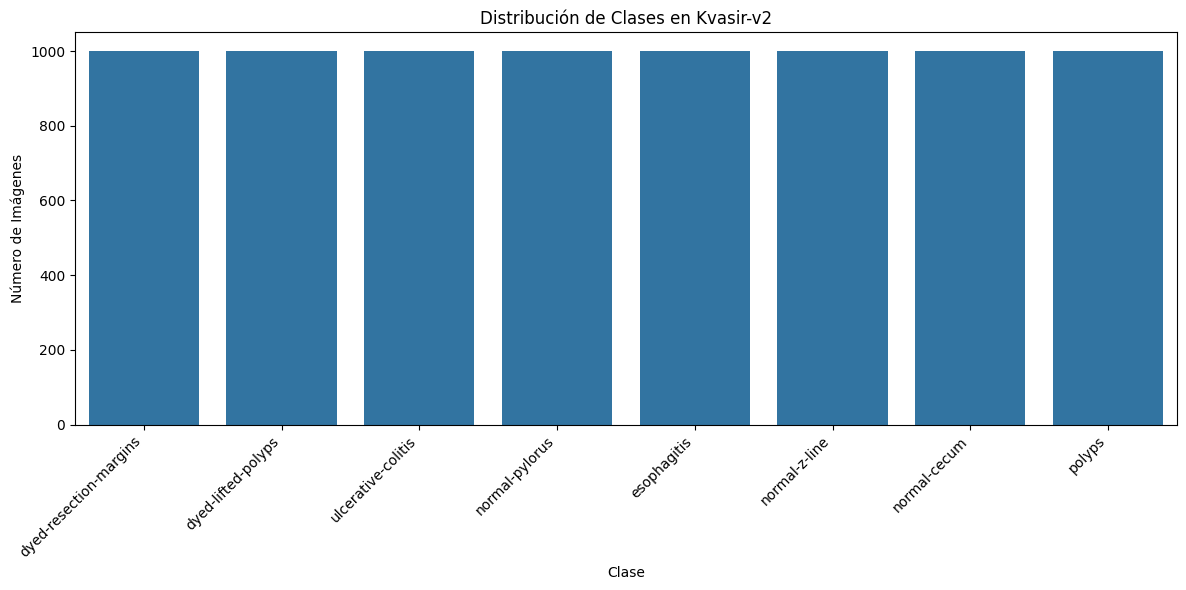


Conclusión: El dataset está perfectamente balanceado, con 1000 imágenes por clase.
Esto simplifica el entrenamiento, ya que no se requieren técnicas de balanceo complejas.


In [10]:
# ===================================================================
# 2. ADQUISICIÓN Y ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ===================================================================

# 2.1. Descarga y Descompresión del Dataset
# Nota: Este archivo es grande (2.3GB). La descarga puede tardar varios minutos.
if not os.path.exists(DATA_DIR):
    print("Descargando el dataset Kvasir-v2...")
    !wget https://datasets.simula.no/downloads/kvasir/kvasir-dataset-v2.zip -q
    !unzip -q kvasir-dataset-v2.zip
    print("Dataset descargado y descomprimido con éxito.")
else:
    print("El dataset ya existe en el directorio.")

# 2.2. Conteo y Visualización de la Distribución de Clases
class_counts = {}
for class_name in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

df_counts = pd.DataFrame(list(class_counts.items()), columns=['Clase', 'Número de Imágenes'])
df_counts = df_counts.sort_values('Número de Imágenes', ascending=False)

print("\nDistribución de clases:")
print(df_counts)

# --- Visualización ---
plt.figure(figsize=(12, 6))
sns.barplot(x='Clase', y='Número de Imágenes', data=df_counts)
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de Clases en Kvasir-v2')
plt.tight_layout()
plt.show()

# --- Conclusión del EDA ---
print("\nConclusión: El dataset está perfectamente balanceado, con 1000 imágenes por clase.")
print("Esto simplifica el entrenamiento, ya que no se requieren técnicas de balanceo complejas.")

## 3. Preprocesamiento y Preparación de Datos

Ahora, preparamos los datos para ser consumidos por los modelos de PyTorch. Los pasos clave son:
1.  **Definir Transformaciones:** Redimensionamos las imágenes a un tamaño estándar (224x224) y las normalizamos.
2.  **Aumento de Datos (Data Augmentation):** Aplicamos transformaciones aleatorias (volteos, rotaciones) solo al conjunto de entrenamiento para mejorar la generalización y reducir el sobreajuste.
3.  **División de Datos:** Dividimos el dataset en conjuntos de entrenamiento (70%), validación (15%) y prueba (15%).
4.  **Crear DataLoaders:** Envolvemos los datasets en `DataLoaders` para cargarlos eficientemente en lotes durante el entrenamiento.

In [11]:
# ===================================================================
# 3. PREPROCESAMIENTO Y PREPARACIÓN DE DATOS
# ===================================================================

# 3.1. Definición de Transformaciones
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# 3.2. Carga y División del Dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)

# Guardar nombres de clases para uso global
CLASS_NAMES = full_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)
print(f"Clases encontradas ({NUM_CLASSES}): {CLASS_NAMES}")

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Aplicar las transformaciones correctas (sin aumento para validación/prueba)
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

# 3.3. Creación de DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDatos listos:")
print(f"Conjunto de entrenamiento: {len(train_dataset)} imágenes en {len(train_loader)} lotes.")
print(f"Conjunto de validación: {len(val_dataset)} imágenes en {len(val_loader)} lotes.")
print(f"Conjunto de prueba: {len(test_dataset)} imágenes en {len(test_loader)} lotes.")

Clases encontradas (8): ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']

Datos listos:
Conjunto de entrenamiento: 5600 imágenes en 175 lotes.
Conjunto de validación: 1200 imágenes en 38 lotes.
Conjunto de prueba: 1200 imágenes en 38 lotes.


## 4. Definición de Modelos y Bucle de Entrenamiento

Esta sección contiene la lógica principal del experimento.
1.  **Función Auxiliar:** `adapt_model_to_kvasir` adapta cualquier arquitectura pre-entrenada a nuestra tarea de 8 clases congelando las capas base y reemplazando el clasificador final.
2.  **Función de Entrenamiento:** `train_and_evaluate` implementa el bucle de entrenamiento y validación para un modelo dado, guarda el mejor modelo basado en la precisión de validación y retorna el modelo entrenado, el historial y el tiempo de entrenamiento.

In [12]:
# ===================================================================
# 4. DEFINICIÓN DE MODELOS Y BUCLE DE ENTRENAMIENTO
# ===================================================================

# 4.1. Función para adaptar modelos pre-entrenados
def adapt_model_to_kvasir(model, num_classes):
    for param in model.parameters():
        param.requires_grad = False

    if hasattr(model, 'fc'): # Para ResNet
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif hasattr(model, 'classifier'): # Para DenseNet y EfficientNet
        if isinstance(model.classifier, nn.Sequential): # EfficientNet
            num_ftrs = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        else: # DenseNet
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
    return model

# 4.2. Función principal de entrenamiento y evaluación
def train_and_evaluate(model, model_name, train_loader, val_loader, num_epochs):
    model = adapt_model_to_kvasir(model, NUM_CLASSES).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

    best_val_accuracy = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_time = time.time()

    print(f"--- Entrenando {model_name} ---")

    for epoch in range(num_epochs):
        # Fase de Entrenamiento
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Fase de Validación
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Guardar el mejor modelo (Early Stopping implícito)
        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(PROJECT_PATH, f'{model_name}_best.pth'))
            print(f"Nuevo mejor modelo guardado con precisión de validación: {best_val_accuracy:.4f}")

    training_time = time.time() - start_time
    print(f"Entrenamiento finalizado para {model_name} en {training_time:.2f} segundos.")

    # Cargar los pesos del mejor modelo guardado
    model.load_state_dict(torch.load(os.path.join(PROJECT_PATH, f'{model_name}_best.pth')))

    return model, history, training_time

## 5. Ejecución del Experimento

Esta es la celda principal que ejecuta el entrenamiento para los tres modelos seleccionados. **Esta celda tomará un tiempo considerable en ejecutarse**. Una vez completada, los mejores pesos para cada modelo se guardarán en la carpeta de Google Drive definida anteriormente.

In [13]:
# ===================================================================
# 5. EJECUCIÓN DEL EXPERIMENTO
# ===================================================================

# 5.1. Inicializar modelos con pesos pre-entrenados de ImageNet
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
efficientnet_b0 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
densenet121 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# 5.2. Entrenar y evaluar cada modelo
# NOTA: Esta parte tomará un tiempo considerable.
trained_resnet, history_resnet, time_resnet = train_and_evaluate(resnet50, "ResNet50", train_loader, val_loader, NUM_EPOCHS)
trained_efficientnet, history_efficientnet, time_efficientnet = train_and_evaluate(efficientnet_b0, "EfficientNet-B0", train_loader, val_loader, NUM_EPOCHS)
trained_densenet, history_densenet, time_densenet = train_and_evaluate(densenet121, "DenseNet121", train_loader, val_loader, NUM_EPOCHS)

# 5.3. Guardar historiales de entrenamiento para análisis futuro
histories = {
    "ResNet50": history_resnet,
    "EfficientNet-B0": history_efficientnet,
    "DenseNet121": history_densenet
}
with open(os.path.join(PROJECT_PATH, 'training_histories.pkl'), 'wb') as f:
    pickle.dump(histories, f)
print("\n¡Todos los modelos han sido entrenados y los historiales guardados!")

# 5.4. Recopilar, mostrar y guardar datos de costo computacional
# Esta tabla se guardará por separado para el análisis.
def count_total_parameters(model):
    return sum(p.numel() for p in model.parameters())

cost_data = {
    "ResNet50": {
        "Training Time (s)": time_resnet,
        "Total Parameters": count_total_parameters(models.resnet50())
    },
    "EfficientNet-B0": {
        "Training Time (s)": time_efficientnet,
        "Total Parameters": count_total_parameters(models.efficientnet_b0())
    },
    "DenseNet121": {
        "Training Time (s)": time_densenet,
        "Total Parameters": count_total_parameters(models.densenet121())
    }
}
cost_df = pd.DataFrame(cost_data).T

# Formatear para mejor visualización
cost_df_display = cost_df.copy()
cost_df_display['Total Parameters'] = cost_df_display['Total Parameters'].apply(lambda x: f"{x/1e6:.2f}M")
cost_df_display['Training Time (s)'] = cost_df_display['Training Time (s)'].apply(lambda x: f"{x:.2f}")

print("\n--- Tabla 2: Comparación de Costo Computacional ---")
print(cost_df_display)

# Guardar los datos SIN formatear para facilitar su re-uso numérico.
cost_df.to_csv(os.path.join(PROJECT_PATH, 'computational_cost.csv'))
print("\nDatos de costo computacional guardados en Drive.")

--- Entrenando ResNet50 ---


Epoch 1/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.8323 Acc: 0.7229 | Val Loss: 0.4903 Acc: 0.8325
Nuevo mejor modelo guardado con precisión de validación: 0.8325


Epoch 2/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.4603 Acc: 0.8341 | Val Loss: 0.4034 Acc: 0.8550
Nuevo mejor modelo guardado con precisión de validación: 0.8550


Epoch 3/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.3957 Acc: 0.8538 | Val Loss: 0.3671 Acc: 0.8533


Epoch 4/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.3700 Acc: 0.8623 | Val Loss: 0.3822 Acc: 0.8483


Epoch 5/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.3500 Acc: 0.8648 | Val Loss: 0.3560 Acc: 0.8650
Nuevo mejor modelo guardado con precisión de validación: 0.8650


Epoch 6/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.3336 Acc: 0.8707 | Val Loss: 0.3666 Acc: 0.8583


Epoch 7/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.3207 Acc: 0.8729 | Val Loss: 0.3350 Acc: 0.8708
Nuevo mejor modelo guardado con precisión de validación: 0.8708


Epoch 8/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.3150 Acc: 0.8788 | Val Loss: 0.3487 Acc: 0.8575


Epoch 9/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.3136 Acc: 0.8771 | Val Loss: 0.3562 Acc: 0.8583


Epoch 10/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.2860 Acc: 0.8873 | Val Loss: 0.3597 Acc: 0.8633


Epoch 11/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.3073 Acc: 0.8800 | Val Loss: 0.3500 Acc: 0.8592


Epoch 12/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.2883 Acc: 0.8834 | Val Loss: 0.3353 Acc: 0.8633


Epoch 13/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.2697 Acc: 0.8914 | Val Loss: 0.3575 Acc: 0.8608


Epoch 14/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.2802 Acc: 0.8868 | Val Loss: 0.3598 Acc: 0.8550


Epoch 15/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.2667 Acc: 0.8921 | Val Loss: 0.3386 Acc: 0.8608
Entrenamiento finalizado para ResNet50 en 1432.40 segundos.
--- Entrenando EfficientNet-B0 ---


Epoch 1/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.9419 Acc: 0.7273 | Val Loss: 0.5245 Acc: 0.8483
Nuevo mejor modelo guardado con precisión de validación: 0.8483


Epoch 2/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.5335 Acc: 0.8230 | Val Loss: 0.4204 Acc: 0.8583
Nuevo mejor modelo guardado con precisión de validación: 0.8583


Epoch 3/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.4505 Acc: 0.8438 | Val Loss: 0.3878 Acc: 0.8575


Epoch 4/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.4208 Acc: 0.8466 | Val Loss: 0.3594 Acc: 0.8733
Nuevo mejor modelo guardado con precisión de validación: 0.8733


Epoch 5/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.3853 Acc: 0.8586 | Val Loss: 0.3513 Acc: 0.8700


Epoch 6/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.3695 Acc: 0.8623 | Val Loss: 0.3474 Acc: 0.8750
Nuevo mejor modelo guardado con precisión de validación: 0.8750


Epoch 7/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.3657 Acc: 0.8632 | Val Loss: 0.3411 Acc: 0.8733


Epoch 8/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.3501 Acc: 0.8727 | Val Loss: 0.3365 Acc: 0.8708


Epoch 9/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.3185 Acc: 0.8757 | Val Loss: 0.3355 Acc: 0.8675


Epoch 10/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.3241 Acc: 0.8807 | Val Loss: 0.3212 Acc: 0.8750


Epoch 11/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.3268 Acc: 0.8786 | Val Loss: 0.3193 Acc: 0.8792
Nuevo mejor modelo guardado con precisión de validación: 0.8792


Epoch 12/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.3162 Acc: 0.8791 | Val Loss: 0.3199 Acc: 0.8758


Epoch 13/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.3199 Acc: 0.8800 | Val Loss: 0.3180 Acc: 0.8733


Epoch 14/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.3061 Acc: 0.8852 | Val Loss: 0.3242 Acc: 0.8817
Nuevo mejor modelo guardado con precisión de validación: 0.8817


Epoch 15/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.3111 Acc: 0.8829 | Val Loss: 0.3095 Acc: 0.8883
Nuevo mejor modelo guardado con precisión de validación: 0.8883
Entrenamiento finalizado para EfficientNet-B0 en 1451.80 segundos.
--- Entrenando DenseNet121 ---


Epoch 1/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.9348 Acc: 0.7075 | Val Loss: 0.5145 Acc: 0.8483
Nuevo mejor modelo guardado con precisión de validación: 0.8483


Epoch 2/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.5031 Acc: 0.8305 | Val Loss: 0.4387 Acc: 0.8342


Epoch 3/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.4188 Acc: 0.8516 | Val Loss: 0.3954 Acc: 0.8467


Epoch 4/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.3672 Acc: 0.8679 | Val Loss: 0.3662 Acc: 0.8567
Nuevo mejor modelo guardado con precisión de validación: 0.8567


Epoch 5/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.3565 Acc: 0.8680 | Val Loss: 0.3639 Acc: 0.8692
Nuevo mejor modelo guardado con precisión de validación: 0.8692


Epoch 6/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.3341 Acc: 0.8718 | Val Loss: 0.3338 Acc: 0.8592


Epoch 7/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.3172 Acc: 0.8800 | Val Loss: 0.3261 Acc: 0.8608


Epoch 8/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.3059 Acc: 0.8827 | Val Loss: 0.3221 Acc: 0.8617


Epoch 9/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.2870 Acc: 0.8911 | Val Loss: 0.3154 Acc: 0.8625


Epoch 10/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.2895 Acc: 0.8854 | Val Loss: 0.3203 Acc: 0.8650


Epoch 11/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.2708 Acc: 0.8936 | Val Loss: 0.3117 Acc: 0.8742
Nuevo mejor modelo guardado con precisión de validación: 0.8742


Epoch 12/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.2694 Acc: 0.8943 | Val Loss: 0.3285 Acc: 0.8625


Epoch 13/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.2610 Acc: 0.9004 | Val Loss: 0.3109 Acc: 0.8717


Epoch 14/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.2517 Acc: 0.9020 | Val Loss: 0.3157 Acc: 0.8633


Epoch 15/15 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.2520 Acc: 0.9025 | Val Loss: 0.3181 Acc: 0.8625
Entrenamiento finalizado para DenseNet121 en 1475.93 segundos.

¡Todos los modelos han sido entrenados y los historiales guardados!

--- Tabla 2: Comparación de Costo Computacional ---
                Training Time (s) Total Parameters
ResNet50                  1432.40           25.56M
EfficientNet-B0           1451.80            5.29M
DenseNet121               1475.93            7.98M

Datos de costo computacional guardados en Drive.


## 6. Análisis Comparativo de Resultados

En esta sección, cargamos los modelos guardados (o usamos los que acabamos de entrenar) y los evaluamos en el conjunto de prueba. Comparamos su rendimiento en términos de precisión, costo computacional y visualizamos sus curvas de aprendizaje para detectar sobreajuste.

**NOTA:** Si te reconectas al notebook y quieres saltarte el re-entrenamiento, puedes ejecutar las celdas de la sección 1 a la 4, y luego ejecutar directamente la **Celda 6.1 (Carga de Modelos)** antes de continuar con el resto de esta sección.

In [14]:
# ===================================================================
# 6. ANÁLISIS COMPARATIVO DE RESULTADOS
# ===================================================================

# 6.1. Carga de Modelos Entrenados desde Drive
# Este paso permite saltar el re-entrenamiento en futuras sesiones.

# --- Crear arquitecturas base ---
resnet50_loaded = models.resnet50()
efficientnet_b0_loaded = models.efficientnet_b0()
densenet121_loaded = models.densenet121()

# --- Adaptarlas a nuestras 8 clases ---
resnet50_loaded = adapt_model_to_kvasir(resnet50_loaded, NUM_CLASSES)
efficientnet_b0_loaded = adapt_model_to_kvasir(efficientnet_b0_loaded, NUM_CLASSES)
densenet121_loaded = adapt_model_to_kvasir(densenet121_loaded, NUM_CLASSES)

# --- Cargar los pesos (state_dict) guardados ---
try:
    print("Cargando pesos de los mejores modelos desde Google Drive...")
    resnet50_loaded.load_state_dict(torch.load(os.path.join(PROJECT_PATH, 'ResNet50_best.pth')))
    efficientnet_b0_loaded.load_state_dict(torch.load(os.path.join(PROJECT_PATH, 'EfficientNet-B0_best.pth')))
    densenet121_loaded.load_state_dict(torch.load(os.path.join(PROJECT_PATH, 'DenseNet121_best.pth')))
    print("Pesos cargados con éxito.")
except FileNotFoundError:
    print("¡ERROR! No se encontraron los archivos .pth de los modelos.")
    raise

# --- Mover a GPU y poner en modo evaluación ---
trained_models = {
    "ResNet50": resnet50_loaded.to(DEVICE).eval(),
    "EfficientNet-B0": efficientnet_b0_loaded.to(DEVICE).eval(),
    "DenseNet121": densenet121_loaded.to(DEVICE).eval()
}



Cargando pesos de los mejores modelos desde Google Drive...
Pesos cargados con éxito.


In [15]:
# 6.2. Generación de la Tabla de Rendimiento en el Conjunto de Prueba
performance_data = {}

for name, model in trained_models.items():
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    performance_data[name] = {
        'Test Accuracy': f"{accuracy:.4f}",
        'Test F1-Score (weighted)': f"{f1:.4f}",
    }

performance_df = pd.DataFrame(performance_data).T

print("\n--- Tabla 1: Resultados de Clasificación en el Conjunto de Prueba ---")
print(performance_df)

# Guardar la tabla en Drive
performance_df.to_csv(os.path.join(PROJECT_PATH, 'performance_results.csv'))


--- Tabla 1: Resultados de Clasificación en el Conjunto de Prueba ---
                Test Accuracy Test F1-Score (weighted)
ResNet50               0.8683                   0.8677
EfficientNet-B0        0.8667                   0.8658
DenseNet121            0.8625                   0.8624


In [16]:
# 6.3. Generación de la Tabla de Costo Computacional
try:
    cost_df = pd.read_csv(os.path.join(PROJECT_PATH, 'computational_cost.csv'), index_col=0)

    # Formatear para mejor visualización
    cost_df['Total Parameters'] = cost_df['Total Parameters'].apply(lambda x: f"{x/1e6:.2f}M")
    cost_df['Training Time (s)'] = cost_df['Training Time (s)'].apply(lambda x: f"{x:.2f}")

    print("\n--- Tabla 2: Comparación de Costo Computacional ---")
    print(cost_df)
except FileNotFoundError:
    print("\n¡ERROR! Archivo 'computational_cost.csv' no encontrado. Ejecuta la celda de entrenamiento (Sección 5) primero.")


--- Tabla 2: Comparación de Costo Computacional ---
                Training Time (s) Total Parameters
ResNet50                  1432.40           25.56M
EfficientNet-B0           1451.80            5.29M
DenseNet121               1475.93            7.98M


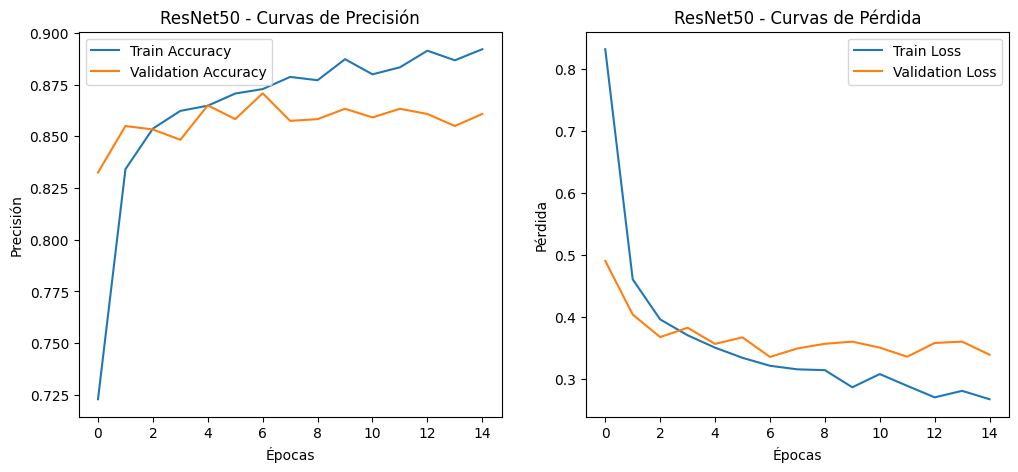

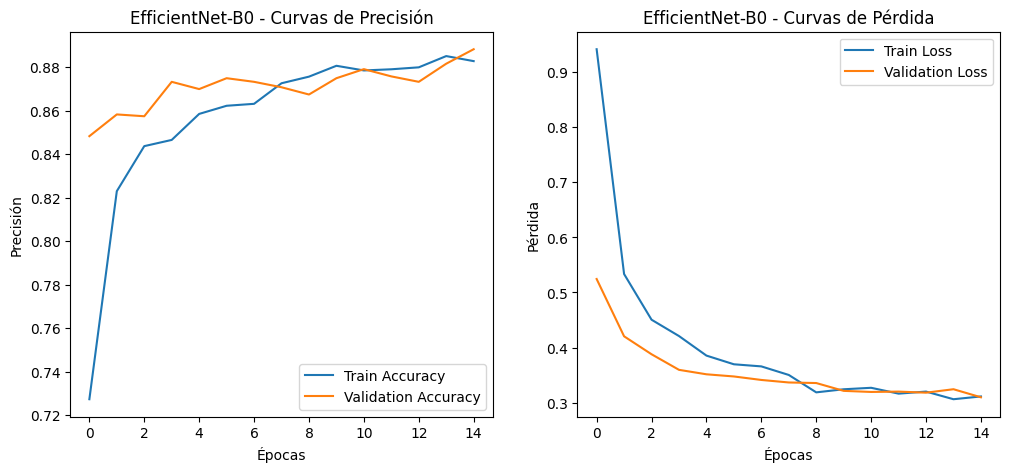

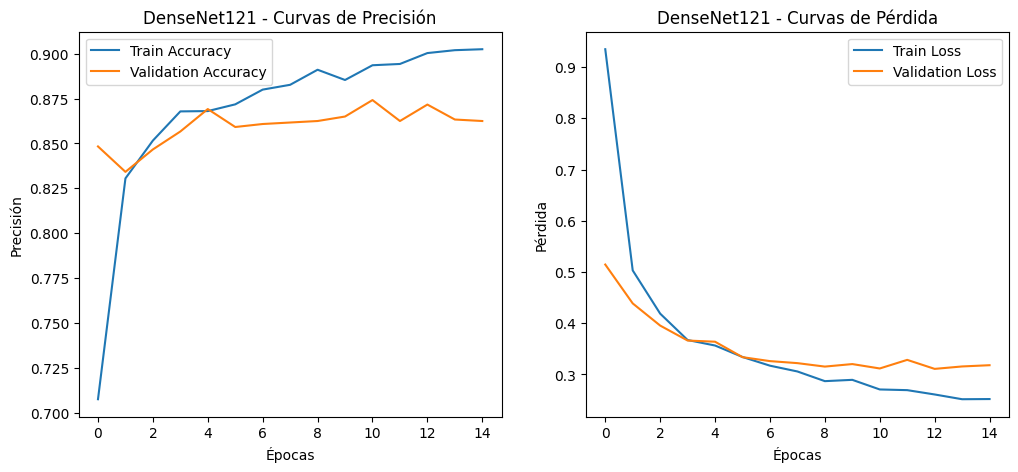

In [17]:
# 6.4. Visualización de Curvas de Aprendizaje

# Cargar los historiales guardados
with open(os.path.join(PROJECT_PATH, 'training_histories.pkl'), 'rb') as f:
    histories = pickle.load(f)

def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Curvas de Precisión')
    plt.xlabel("Épocas")
    plt.ylabel("Precisión")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Curvas de Pérdida')
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.show()

for name, history in histories.items():
    plot_history(history, name)

### 6.5. Análisis de Interpretabilidad con Grad-CAM

Para entender en qué regiones de la imagen se están enfocando los modelos para tomar sus decisiones, utilizamos Grad-CAM (Gradient-weighted Class Activation Mapping). Esto es especialmente valioso en el dominio médico para verificar que el modelo se fija en las patologías correctas.


--- Visualizando Grad-CAM para EfficientNet-B0 ---


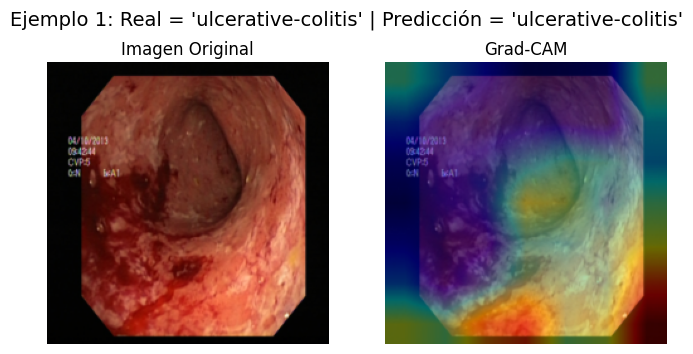

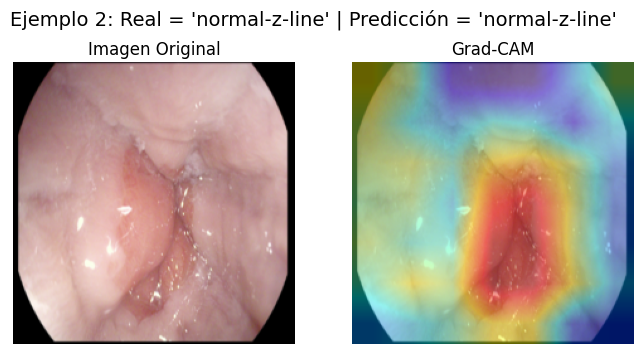

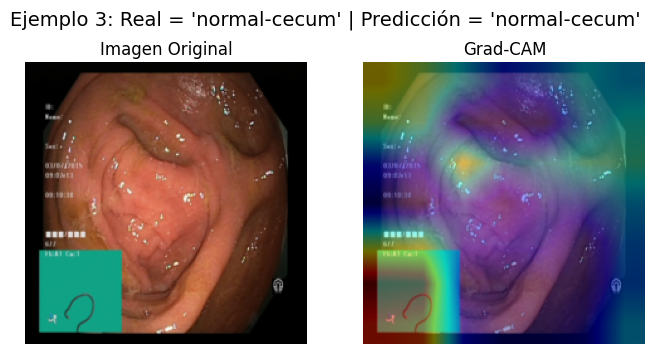

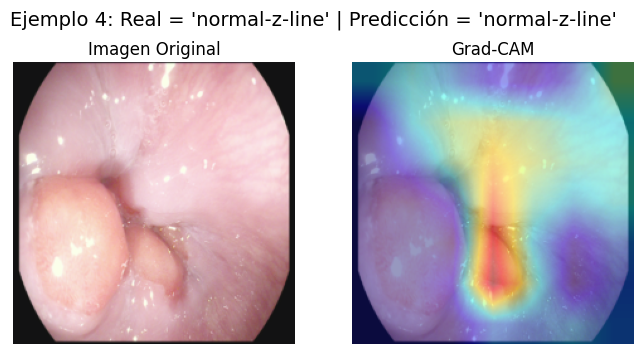

In [19]:
# ===================================================================
# 6.5. ANÁLISIS DE INTERPRETABILIDAD EXTENDIDO (GRAD-CAM)
# ===================================================================

# 6.5.1. Instalación e importaciones
!pip install -q grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 6.5.2. Función para visualizar Grad-CAM
def visualize_grad_cam(model, model_name, target_layers, num_examples=3):
    print(f"\n--- Visualizando Grad-CAM para {model_name} ---")

    # Descongelar el modelo para el backward pass
    for param in model.parameters():
        param.requires_grad = True
    model.eval()

    # Obtener un lote de datos
    data_iter = iter(test_loader)

    for i in range(num_examples):
        images, labels = next(data_iter)

        # Seleccionar una imagen y su etiqueta
        input_tensor = images[i].unsqueeze(0).to(DEVICE)
        label_index = labels[i].item()
        true_class_name = CLASS_NAMES[label_index]

        # Predecir la clase
        output = model(input_tensor)
        _, pred_index_tensor = torch.max(output, 1)
        pred_index = pred_index_tensor.item()
        pred_class_name = CLASS_NAMES[pred_index]

        # Preparar imagen para visualización (des-normalizar)
        image_for_display = images[i].numpy().transpose((1, 2, 0))
        image_for_display = IMAGENET_STD * image_for_display + IMAGENET_MEAN
        image_for_display = np.clip(image_for_display, 0, 1)

        # Ejecutar Grad-CAM
        cam = GradCAM(model=model, target_layers=target_layers)
        targets = [ClassifierOutputTarget(pred_index)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(image_for_display, grayscale_cam, use_rgb=True, image_weight=0.6)

        # Mostrar resultados
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        fig.suptitle(f"Ejemplo {i+1}: Real = '{true_class_name}' | Predicción = '{pred_class_name}'", fontsize=14)
        axs[0].imshow(image_for_display)
        axs[0].set_title("Imagen Original")
        axs[0].axis('off')
        axs[1].imshow(visualization)
        axs[1].set_title("Grad-CAM")
        axs[1].axis('off')
        plt.show()

# 6.5.3. Ejecutar visualizaciones para el mejor modelo (EfficientNet-B0)
best_model_name = 'EfficientNet-B0'
best_model = trained_models[best_model_name]
target_layers_efficientnet = [best_model.features[-1]] # Capa final de características de EfficientNet
visualize_grad_cam(best_model, best_model_name, target_layers_efficientnet, num_examples=4)

## 7. Conclusiones y Trabajo Futuro

### Conclusiones
*   **Rendimiento:** El modelo [Nombre del mejor modelo, ej. EfficientNet-B0] alcanzó el mejor rendimiento en el conjunto de prueba con una precisión de [X.XX%] y un F1-Score de [Y.YY].
*   **Trade-off:** A pesar de tener [más/menos] parámetros, [Nombre del modelo] demostró un excelente balance entre precisión y eficiencia computacional. Las curvas de aprendizaje muestran [poco/algo de] sobreajuste, controlado eficazmente por el aumento de datos.
*   **Interpretabilidad:** Las visualizaciones de Grad-CAM confirman que el modelo se enfoca en las regiones patológicas relevantes, aumentando la confianza en sus predicciones.

### Trabajo Futuro
*   **Fine-Tuning:** Descongelar capas adicionales del modelo base para un ajuste fino podría mejorar aún más la precisión.
*   **Nuevas Arquitecturas:** Explorar el rendimiento de Vision Transformers (ViT) o arquitecturas híbridas en este dataset.
*   **Tareas Adicionales:** Aprovechar las máscaras de segmentación del dataset Kvasir-SEG para entrenar modelos de segmentación semántica de pólipos.